<a href="https://colab.research.google.com/github/Yasir323/100-days-of-code/blob/master/Ensemble_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

 A group of
predictors is called an ensemble; thus, this technique is called **Ensemble Learning**,
and an Ensemble Learning algorithm is called an **Ensemble method**.

We can train a group of Decision Tree
classifiers, each on a different random subset of the training set. To make predictions,
you obtain the predictions of all the individual trees, then predict the class that gets
the most votes (see the last exercise in Chapter 6). Such an ensemble of Decision
Trees is called a **Random Forest**.

## Voting Classifier
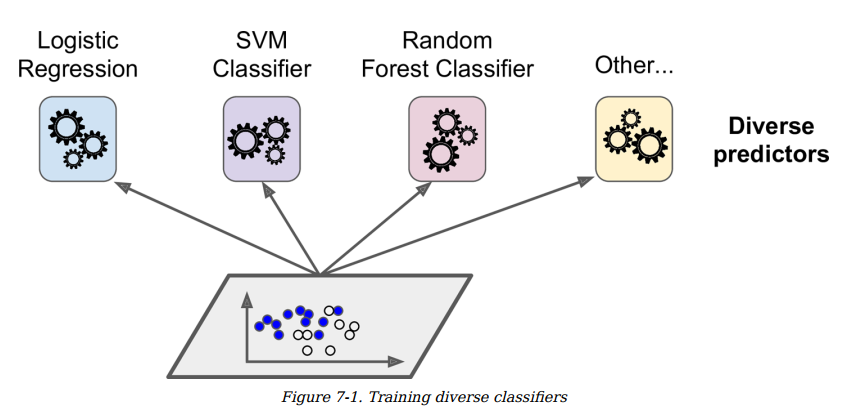

A very simple way to create an even better classifier is to aggregate the predictions of each classifier and predict the class that gets the most votes. This majority-vote
classifier is called a hard voting classifier.

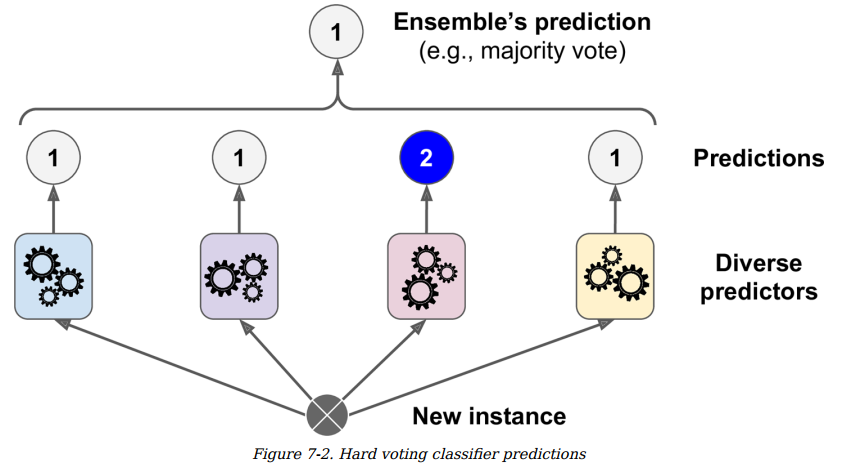

In fact, even if each classifier is a **weak learner**
(meaning it does only slightly better than random guessing), the ensemble can still be
a **strong learner** (achieving high accuracy), provided there are a sufficient number of
weak learners and they are sufficiently diverse.

How is this possible? The following analogy can help shed some light on this mystery.
Suppose you have a slightly biased coin that has a 51% chance of coming up heads
and 49% chance of coming up tails. If you toss it 1,000 times, you will generally get
more or less 510 heads and 490 tails, and hence a majority of heads. If you do the math, you will find that the probability of obtaining a majority of heads after 1,000
tosses is close to 75%. The more you toss the coin, the higher the probability (e.g.,
with 10,000 tosses, the probability climbs over 97%). This is due to the ***law of large
numbers***: as you keep tossing the coin, the ratio of heads gets closer and closer to the
probability of heads (51%).

In [3]:
heads_prob = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_prob).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

Saving figure LawOfLargeNumbers


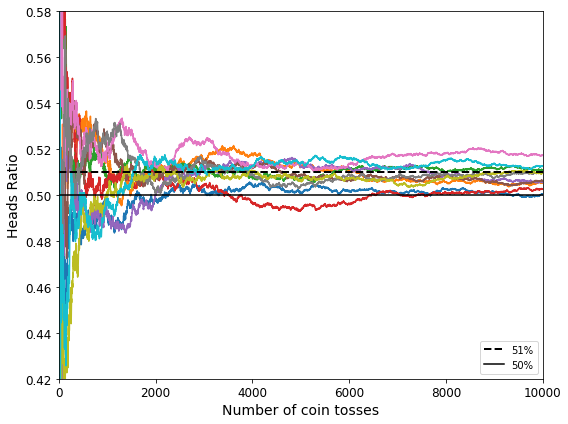

In [8]:
plt.figure(figsize=(8, 6))
plt.plot(cumulative_heads_ratio)
# Draw the 51% line
plt.plot([0, 10000], [0.51, 0.51], 'k--', linewidth=2, label='51%')
# Draw the 50% line
plt.plot([0, 10000], [0.5, 0.5], 'k', label='50%')
plt.xlabel('Number of coin tosses')
plt.ylabel('Heads Ratio')
plt.legend(loc='lower right')
plt.axis([0, 10000, 0.42, 0.58])
save_fig('LawOfLargeNumbers')
plt.show()

Similarly, suppose you build an ensemble containing 1,000 classifiers that are
individually correct only 51% of the time (barely better than random guessing). If you
predict the majority voted class, you can hope for up to 75% accuracy! However, this
is only true if all classifiers are perfectly independent, making uncorrelated errors,
which is clearly not the case because they are trained on the same data. They are
likely to make the same types of errors, so there will be many majority votes for the
wrong class, reducing the ensemble’s accuracy.

Ensemble methods work best when the predictors are as independent from one another as possible. One
way to get diverse classifiers is to train them using very different algorithms. This increases the chance
that they will make very different types of errors, improving the ensemble’s accuracy

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

In [10]:
X, y = make_moons(
    n_samples=500,
    noise=0.30,
    random_state=42
)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [14]:
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf),
               ('rf', rnd_clf),
               ('svc', svm_clf)],
    voting='hard'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                             

In [15]:
from sklearn.metrics import accuracy_score

In [16]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.888


If all classifiers are able to estimate class probabilities (i.e., they all have a
predict_proba() method), then you can tell Scikit-Learn to predict the class with the
highest class probability, averaged over all the individual classifiers. This is called soft
voting. It often achieves higher performance than hard voting because it gives more
weight to highly confident votes. All you need to do is replace voting="hard" with
voting="soft" and ensure that all classifiers can estimate class probabilities. This is
not the case for the SVC class by default, so you need to set its probability
hyperparameter to True (this will make the SVC class use cross-validation to estimate
class probabilities, slowing down training, and it will add a predict_proba() method).

In [17]:
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC(probability=True)
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf),
               ('rf', rnd_clf),
               ('svc', svm_clf)],
    voting='soft'
)
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.88
SVC 0.896
VotingClassifier 0.912


As we can see, soft voing does better than hard voting.

## Bagging and Pasting
Another approach is to use the same training algorithm for every
predictor and train them on different random subsets of the training set. When
sampling is performed with replacement, this method is called bagging (short for
bootstrap aggregating ). When sampling is performed without replacement, it is
called pasting.

Once all predictors are trained, the ensemble can make a prediction for a new
instance by simply aggregating the predictions of all predictors. The aggregation
function is typically the statistical mode (i.e., the most frequent prediction, just like a
hard voting classifier) for classification, or the average for regression.Generally, the net result is that the
ensemble has a similar bias but a lower variance than a single predictor trained on
the original training set.

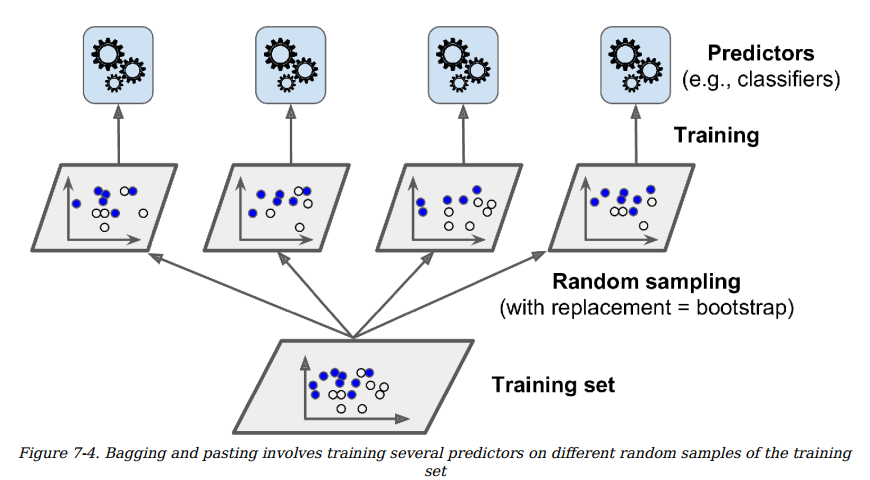

In [18]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [19]:
bag_clf = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(),
    n_estimators=500,
    max_samples=100,
    bootstrap=True,
    n_jobs=-1
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.904

The BaggingClassifier automatically performs soft voting instead of hard voting if the base classifier can
estimate class probabilities (i.e., if it has a predict_proba() method), which is the case with Decision Tree
classifiers.

Bootstrapping introduces a bit more diversity in the subsets that each predictor is
trained on, so bagging ends up with a slightly higher bias than pasting; but the extra
diversity also means that the predictors end up being less correlated, so the
ensemble’s variance is reduced. Overall, bagging often results in better models,
which explains why it is generally preferred.

In [20]:
# Decision Tree Classifier
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [21]:
from matplotlib.colors import ListedColormap

In [22]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

Saving figure decision_tree_without_and_with_bagging_plot


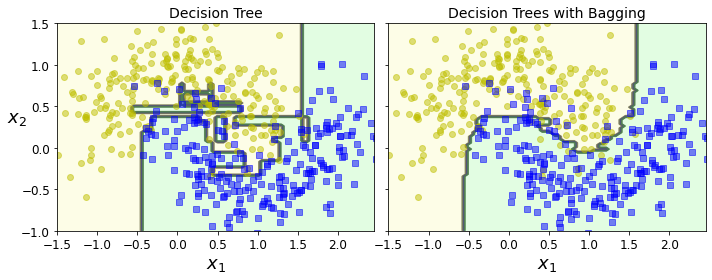

In [23]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

### Out-of-bag Evaluation
With bagging, some instances may be sampled several times for any given predictor,
while others may not be sampled at all. By default a BaggingClassifier samples m
training instances with replacement (bootstrap=True), where m is the size of the
training set. This means that only about 63% of the training instances are sampled on
average for each predictor. The remaining 37% of the training instances that are not
sampled are called out-of-bag (oob) instances.

Since a predictor never sees the oob instances during training, it can be evaluated on
these instances, without the need for a separate validation set. In Scikit-Learn, you can set oob_score=True when creating a BaggingClassifier to
request an automatic oob evaluation after training.

In [24]:
bag_clf = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(),
    n_estimators=500,
    max_samples=100,
    bootstrap=True,
    n_jobs=-1,
    oob_score=True
)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9226666666666666

In [25]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

In [26]:
bag_clf.oob_decision_function_

array([[0.296875  , 0.703125  ],
       [0.4229765 , 0.5770235 ],
       [0.99754902, 0.00245098],
       [0.0129199 , 0.9870801 ],
       [0.03141361, 0.96858639],
       [0.08163265, 0.91836735],
       [0.38461538, 0.61538462],
       [0.07486631, 0.92513369],
       [0.94195251, 0.05804749],
       [0.80628272, 0.19371728],
       [0.53723404, 0.46276596],
       [0.05974026, 0.94025974],
       [0.75797872, 0.24202128],
       [0.83419689, 0.16580311],
       [0.92146597, 0.07853403],
       [0.10789474, 0.89210526],
       [0.02813299, 0.97186701],
       [0.90673575, 0.09326425],
       [0.64266667, 0.35733333],
       [0.94230769, 0.05769231],
       [0.05221932, 0.94778068],
       [0.23214286, 0.76785714],
       [0.8974359 , 0.1025641 ],
       [0.98944591, 0.01055409],
       [0.97135417, 0.02864583],
       [0.00516796, 0.99483204],
       [0.95663957, 0.04336043],
       [1.        , 0.        ],
       [0.02051282, 0.97948718],
       [0.77023499, 0.22976501],
       [0.

### Random Patches and Random Subspaces
The BaggingClassifier class supports sampling the features as well. Sampling is
controlled by two hyperparameters: `max_features` and `bootstrap_features`.

This technique is particularly useful when you are dealing with high-dimensional
inputs (such as images). Sampling both training instances and features is called the
**Random Patches method**. Keeping all training instances (by setting `bootstrap=False`
and `max_samples=1.0`) but sampling features (by setting `bootstrap_features` to `True` and/or
`max_features` to a value smaller than `1.0`) is called the **Random Subspaces method**.

## Random Forests
A Random Forest is an ensemble of Decision Trees, generally
trained via the bagging method.

In [30]:
rnd_clf = RandomForestClassifier(
    n_estimators=500,
    max_leaf_nodes=16,
    n_jobs=-1,
    random_state=42
)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

In [31]:
accuracy_score(y_test, y_pred_rf)

0.912

The Random Forest algorithm introduces extra randomness when growing trees;
instead of searching for the very best feature when splitting a node (see Chapter 6), it
searches for the best feature among a random subset of features. The algorithm
results in greater tree diversity, which (again) trades a higher bias for a lower
variance, generally yielding an overall better model.

### Extra-Trees
 It is possible to make
trees even more random by also using random thresholds for each feature rather than
searching for the best possible thresholds (like regular Decision Trees do).

A forest of such extremely random trees is called an Extremely Randomized Trees
ensemble (or Extra-Trees for short). Once again, this technique trades more bias for
a lower variance. It also makes Extra-Trees much faster to train than regular Random
Forests.

In [29]:
from sklearn.ensemble import ExtraTreesClassifier

In [32]:
ext_clf = ExtraTreesClassifier(
    n_estimators=500,
    max_leaf_nodes=16,
    n_jobs=-1,
    random_state=42
)
ext_clf.fit(X_train, y_train)
y_pred_ext = ext_clf.predict(X_test)
accuracy_score(y_test, y_pred_ext)

0.912

### Feature Importance

In [33]:
from sklearn.datasets import load_iris

In [35]:
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.10617489252816684
sepal width (cm) 0.02471767288165618
petal length (cm) 0.4338859376770839
petal width (cm) 0.43522149691309303


Let's try this on MNIST dataset to see which pixels are most important

In [36]:
from sklearn.datasets import fetch_openml

In [37]:
mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [38]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [39]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

Saving figure mnist_feature_importance_plot


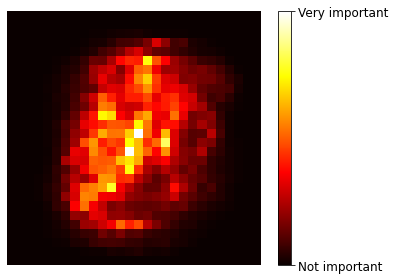

In [40]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

## Boosting
Boosting (originally called hypothesis boosting) refers to any Ensemble method that
can combine several weak learners into a strong learner. The general idea of most boosting methods is to train predictors sequentially, each trying to correct its
predecessor.

### Adaboost
One way for a new predictor to correct its predecessor is to pay a bit more attention
to the training instances that the predecessor underfitted. This results in new
predictors focusing more and more on the hard cases. This is the technique used by
AdaBoost.

For example, when training an AdaBoost classifier, the algorithm first trains a base
classifier (such as a Decision Tree) and uses it to make predictions on the training set.
The algorithm then increases the relative weight of misclassified training instances.
Then it trains a second classifier, using the updated weights, and again makes
predictions on the training set, updates the instance weights, and so on.

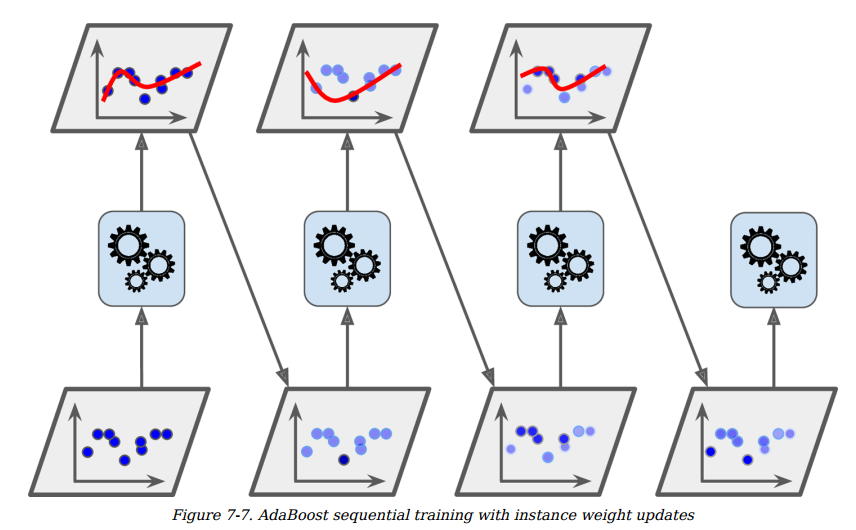

Scikit-Learn uses a multiclass version of AdaBoost called SAMME (which stands for
Stagewise Additive Modeling using a Multiclass Exponential loss function). When
there are just two classes, SAMME is equivalent to AdaBoost. If the predictors can
estimate class probabilities (i.e., if they have a predict_proba() method), Scikit-Learn
can use a variant of SAMME called SAMME.R (the R stands for “Real”), which relies
on class probabilities rather than predictions and generally performs better.

In [41]:
from sklearn.ensemble import AdaBoostClassifier

In [42]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200,
    algorithm='SAMME.R',
    learning_rate=0.5
)
ada_clf1 = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200,
    algorithm='SAMME.R',
    learning_rate=1
)
ada_clf.fit(X_train, y_train)
ada_clf1.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [44]:
accuracy_score(y_test, ada_clf.predict(X_test))

0.896

In [45]:
accuracy_score(y_test, ada_clf1.predict(X_test))

0.872

### Gradient Boosting
Instead of tweaking the instance weights at
every iteration like AdaBoost does, this method tries to fit the new predictor to the
residual errors made by the previous predictor. Lets implement it manually.

In [46]:
from sklearn.tree import DecisionTreeRegressor

In [48]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)
tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([0.75026781])

In [49]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

In [50]:
from sklearn.ensemble import GradientBoostingRegressor

In [51]:
gbrt = GradientBoostingRegressor(
    max_depth=2,
    n_estimators=3,
    learning_rate=1.0
)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

The learning_rate hyperparameter scales the contribution of each tree. If you set it to
a low value, such as 0.1, you will need more trees in the ensemble to fit the training
set, but the predictions will usually generalize better. This is a regularization
technique called shrinkage. 

Saving figure gradient_boosting_plot


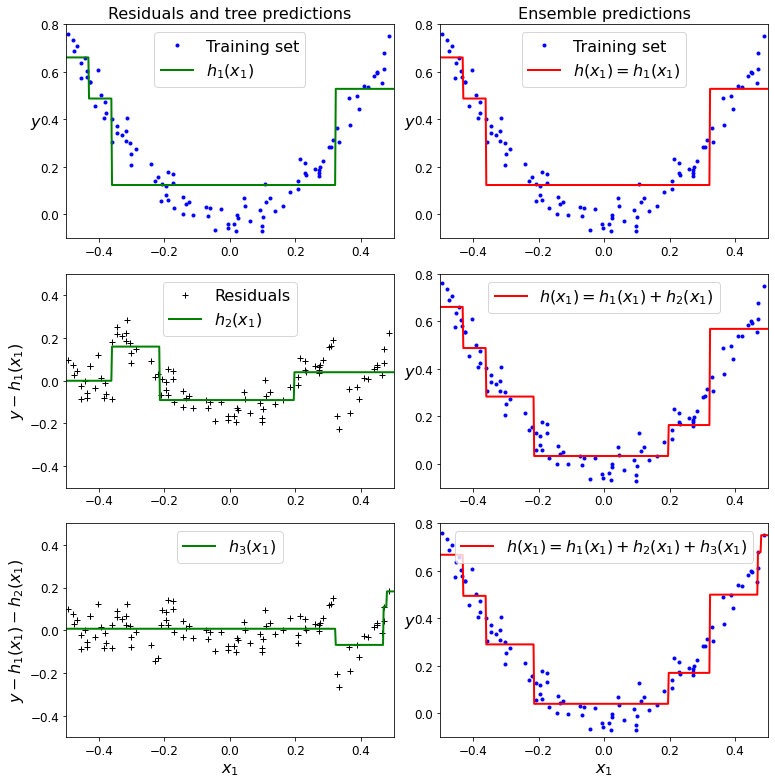

In [52]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

In [53]:
gbrt_fast = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [54]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Saving figure gbrt_learning_rate_plot


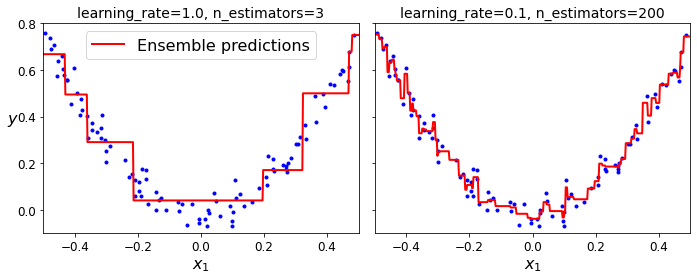

In [55]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

save_fig("gbrt_learning_rate_plot")
plt.show()

We can see that the model on the right is overfitting.

In order to find the optimal number of trees, you can use early stopping (see Chapter
4). A simple way to implement this is to use the staged_predict() method: it returns an
iterator over the predictions made by the ensemble at each stage of training (with
one tree, two trees, etc.).

In [57]:
from sklearn.metrics import mean_squared_error

In [58]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=56,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [59]:
min_error = np.min(errors)

Saving figure early_stopping_gbrt_plot


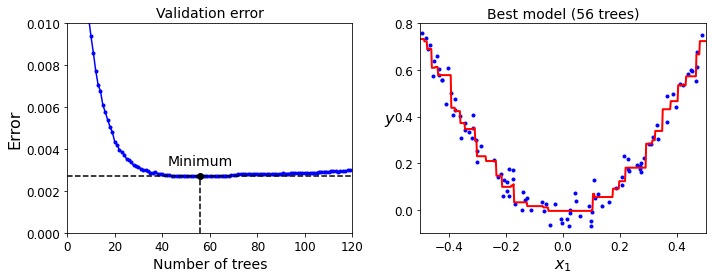

In [60]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("early_stopping_gbrt_plot")
plt.show()

It is also possible to implement early stopping by actually stopping training early
(instead of training a large number of trees first and then looking back to find the
optimal number). You can do so by setting warm_start=True, which makes Scikit-Learn
keep existing trees when the fit() method is called, allowing incremental training.
The following code stops training when the validation error does not improve for five
iterations in a row:

In [61]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [62]:
print(gbrt.n_estimators)

61


In [63]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


The GradientBoostingRegressor class also supports a subsample hyperparameter, which
specifies the fraction of training instances to be used for training each tree. For
example, if subsample=0.25, then each tree is trained on 25% of the training instances,
selected randomly. As you can probably guess by now, this technique trades a higher
bias for a lower variance. It also speeds up training considerably. This is called
Stochastic Gradient Boosting.

## Using XGBoost

In [64]:
try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed.")
    xgboost = None

In [67]:
if xgboost is not None:  # not shown in the book
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred) # Not show
    print("Validation MSE:", val_error)           # Not shown

[07:20:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation MSE: 0.0028512559726563943


XGBoost also offers several nice features, such as automatically taking care of early
stopping:

In [69]:
if xgboost is not None:  # not shown in the book
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], early_stopping_rounds=5)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)  # Not shown
    print("Validation MSE:", val_error)            # Not shown

[07:23:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.286719
Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:0.258221
[2]	validation_0-rmse:0.232634
[3]	validation_0-rmse:0.210526
[4]	validation_0-rmse:0.190232
[5]	validation_0-rmse:0.172196
[6]	validation_0-rmse:0.156394
[7]	validation_0-rmse:0.142241
[8]	validation_0-rmse:0.129789
[9]	validation_0-rmse:0.118752
[10]	validation_0-rmse:0.108388
[11]	validation_0-rmse:0.100155
[12]	validation_0-rmse:0.09208
[13]	validation_0-rmse:0.084791
[14]	validation_0-rmse:0.078699
[15]	validation_0-rmse:0.073248
[16]	validation_0-rmse:0.069391
[17]	validation_0-rmse:0.066277
[18]	validation_0-rmse:0.063458
[19]	validation_0-rmse:0.060326
[20]	validation_0-rmse:0.0578
[21]	validation_0-rmse:0.055643
[22]	validation_0-rmse:0.053943
[23]	validation_0-rmse:0.053138
[24]	validation_0-rmse:0.052415
[25]	validation_0-rmse

In [71]:
import warnings
warnings.filterwarnings('ignore')

In [72]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None

[07:26:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:26:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:26:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:26:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:26:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:26:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:26:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:26:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [73]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

10 loops, best of 5: 24 ms per loop


## Stacking

In [74]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

In [80]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    mnist.data, mnist.target, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42)

In [81]:
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
svm_clf = LinearSVC(random_state=42)
mlp_clf = MLPClassifier(random_state=42)

In [82]:
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)

Training the RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Training the ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                 

In [83]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

In [84]:
X_val_predictions

array([[5., 5., 8., 5.],
       [8., 8., 8., 8.],
       [2., 2., 2., 2.],
       ...,
       [7., 7., 7., 7.],
       [6., 6., 6., 6.],
       [7., 7., 7., 7.]], dtype=float32)

In [85]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rnd_forest_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [86]:
rnd_forest_blender.oob_score_

0.9704

You could fine-tune this blender or try other types of blenders (e.g., an `MLPClassifier`), then select the best one using cross-validation, as always.

In [87]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [88]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [89]:
accuracy_score(y_test, y_pred)

0.9655